In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import tsplib95
import random

problem = tsplib95.load(r'./bayg29.tsp')

problem uzayi icin gerekli olan degerler

In [2]:
farkli_renk_miktari = len(list(problem.get_nodes()))

populasyon_sayisi = 100
secilen_birey_sayisi = 20

renkler_arasi_zaman_maks = 999999

her_jenerasyonda_yeni_birey_sayisi = 100

In [3]:
renkler_arasi_zaman = np.zeros((farkli_renk_miktari, farkli_renk_miktari))
for i in range(farkli_renk_miktari):
    for j in range(farkli_renk_miktari):
        renkler_arasi_zaman[i][j] = problem.get_weight(i+1,j+1)
        if i == j:
            renkler_arasi_zaman[i][j] = renkler_arasi_zaman_maks

farkli renkler arasinda gecen sureleri belirleyelim. TSP'ye benzer olması için işlere önce x ve y koordinatları verip, daha sonra uzaklıkları hesaplayalım. (islerin 10'a 10'luk bir kare icinde oldugunu var sayalim)

renklerin_koordinatlari = np.random.uniform(0,10,(farkli_renk_miktari, 2))

renkler_arasi_zaman = np.zeros((farkli_renk_miktari, farkli_renk_miktari))

for i in range(farkli_renk_miktari):
    for j in range(farkli_renk_miktari):
        x = abs(renklerin_koordinatlari[i][0]-renklerin_koordinatlari[j][0])
        y = abs(renklerin_koordinatlari[i][1]-renklerin_koordinatlari[j][1])
        renkler_arasi_zaman[i][j] = math.sqrt(x**2+y**2)
        if i == j:
            renkler_arasi_zaman[i][i] = 2*renkler_arasi_zaman_maks

Genetik algoritma icin degerlerin tanimlanmasi

In [5]:
max_iterasyon = 100

max_crossover_olasiligi = 0.8
min_crossover_olasiligi = 0.6

max_mutasyon_olasiligi = 0.8
min_mutasyon_olasiligi = 0.6

iterasyon sayisi ilerledikce crossover olasiligi azalip, mutasyon olasiligi artacak

Bunu yapmamizin sebebi, ilk iterasyonlarda exploration sonrasinda, buldundugumuz yerleri exploit etme istegimizdir. Crossover yapmak mutasyona gore uzayda bulundugumuz konumu daha fazla degistirecektir

In [6]:
def crossover_olasiligi(iterasyon):
    return max_crossover_olasiligi - (max_crossover_olasiligi-min_crossover_olasiligi)*iterasyon/max_iterasyon

In [7]:
def mutasyon_olasiligi(iterasyon):
    return min_mutasyon_olasiligi + (max_mutasyon_olasiligi-min_mutasyon_olasiligi)*iterasyon/max_iterasyon


constructive heuristic modeli ilk populasyonu belirlemek icin kullaniyoruz, bize daha iyi bir initial point veriyor

In [8]:
def greedy_sira():
    sira = np.zeros(farkli_renk_miktari)
    ilk_renk = np.random.randint(farkli_renk_miktari)
    sira[0] = ilk_renk
    
    greedy_renkler_arasi_zaman = np.copy(renkler_arasi_zaman)
    
    for i in range(1, farkli_renk_miktari):
        sira[i] = np.argmin(greedy_renkler_arasi_zaman[int(sira[i-1])])
        greedy_renkler_arasi_zaman[int(sira[i-1]),:] = 2*renkler_arasi_zaman_maks
        greedy_renkler_arasi_zaman[:,int(sira[i-1])] = 2*renkler_arasi_zaman_maks
    return sira

Sirada gecirilen sureyi minimalize etmek istedigimiz icin deger fonksiyonu olarak 1/gecen sure kullandik

In [9]:
def siranin_degeri(sira):
    deger = 0
    for i in range(farkli_renk_miktari-1):
        deger = deger + renkler_arasi_zaman[int(sira[i])][int(sira[i+1])]
    return 1/deger

en iyi sira degeri

In [10]:
def en_iyi_deger(populasyon):
    deger = 0
    for i in range(len(populasyon)):
        if siranin_degeri(populasyon[i]) > deger:
            deger = siranin_degeri(populasyon[i])
    
    return deger


greedy olarak elde ettigimiz siradan yeni bireyler elde etmek icin 2 Opt algoritmasini kullandik

In [11]:
def twoOptSwap(sira, i, k):
    yeni_sira = sira
    yeni_sira[i:k+1] = np.flip(sira[i:k+1])
    return yeni_sira

In [12]:
def populasyonun_olusturulmasi(sira):
    populasyon = np.zeros((populasyon_sayisi, farkli_renk_miktari))
    populasyon[0,:] = sira
    for i in range(populasyon_sayisi-1):
        j = np.random.randint(farkli_renk_miktari)
        k = np.random.randint(farkli_renk_miktari)
        if j > k:
            yeni_sira = twoOptSwap(sira, k, j)
        else:
            yeni_sira = twoOptSwap(sira, j, k)
        populasyon[i+1] = yeni_sira
    return populasyon

olusturulan populasyondan en iyi bireylerin secilmesi

In [13]:
def en_iyi_bireyler(populasyon, en_iyi_birey_sayisi):
    bireylerin_degerleri = np.zeros(len(populasyon))
    en_iyi_birey_populasyonu = np.zeros((en_iyi_birey_sayisi, farkli_renk_miktari))
    
    for i in range(len(populasyon)):
        bireylerin_degerleri[i] = siranin_degeri(populasyon[i])
    
    for i in range(en_iyi_birey_sayisi):
        index = np.argmax(bireylerin_degerleri)
        en_iyi_birey_populasyonu[i] = populasyon[index]
        bireylerin_degerleri[index] = 0
    
    return en_iyi_birey_populasyonu

In [14]:
def en_iyi_birey(populasyon):
    deger = 99999
    index = 0
    for i in range(len(populasyon)):
        if siranin_degeri(populasyon[i]) < deger:
            index = i
    
    return populasyon[index]

genetic algoritmayi beslemek icin, populasyonumuza random olarak olusturulmus bireyler ekliyoruz

In [15]:
def random_populasyon_olusturulmasi():
    populasyon = np.zeros((populasyon_sayisi, farkli_renk_miktari))
    base_birey = np.arange(farkli_renk_miktari)
    for i in range(populasyon_sayisi):
        random.shuffle(base_birey)
        populasyon[i] = base_birey
    
    en_iyi_random_populasyon = en_iyi_bireyler(populasyon, secilen_birey_sayisi)
    return en_iyi_random_populasyon

In [16]:
def random_greedy_populasyon():
    populasyon = greedy_sira()
    yeni_populasyon = populasyonun_olusturulmasi(populasyon)
    return en_iyi_bireyler(yeni_populasyon, secilen_birey_sayisi)

Parentlari rulet yontemi ile belirledik

In [17]:
def ebeveyn_secimi(ebeveynler):
    ebeveyn_skorlari = np.zeros(len(ebeveynler))
    ebeveyn_skorlari[0] = siranin_degeri(ebeveynler[0])
    es = np.zeros(len(ebeveynler))
    
    for i in range(1, len(ebeveynler)):
        ebeveyn_skorlari[i] = ebeveyn_skorlari[i-1] + siranin_degeri(ebeveynler[i])
        es[i] = siranin_degeri(ebeveynler[i])
        
    toplam_skor = ebeveyn_skorlari[-1]
    
    secim = np.random.uniform(0,toplam_skor)
    
    for j in range(len(ebeveynler)):
        if ebeveyn_skorlari[j] > secim:
            return ebeveynler[j]

crossover fonksiyonumuz asagidaki gibidir

In [18]:
def crossover(ebeveyn1, ebeveyn2, iterasyon):
    yeni_bireyler = np.zeros((2, farkli_renk_miktari))
    yeni_bireyler[0] = ebeveyn1
    yeni_bireyler[1] = ebeveyn2
    
    if np.random.uniform(0,1) < crossover_olasiligi(iterasyon):
        crossover_noktasi = np.random.randint(farkli_renk_miktari)
        
        for i in range(crossover_noktasi):
            index1 = np.where(yeni_bireyler[0] == ebeveyn2[i])
            temp1 = yeni_bireyler[0][index1]
            yeni_bireyler[0][index1] = yeni_bireyler[0][i]
            yeni_bireyler[0][i] = temp1
            
            index2 = np.where(yeni_bireyler[1] == ebeveyn1[i])
            temp2 = yeni_bireyler[1][index2]
            yeni_bireyler[1][index2] = yeni_bireyler[1][i]
            yeni_bireyler[1][i] = temp2
            
    return yeni_bireyler

In [19]:
def mutasyon(birey, iterasyon):
    mutasyon_bireyi = np.zeros((1,farkli_renk_miktari))
    
    if np.random.uniform(0,1) < mutasyon_olasiligi(iterasyon):
        index1 = np.random.randint(farkli_renk_miktari)
        index2 = np.random.randint(farkli_renk_miktari)
        
        temp = birey[index1]
        birey[index1] = birey[index2]
        birey[index2] = temp
    
    
    for i in range(farkli_renk_miktari):
        mutasyon_bireyi[0][i] = birey[i]
        
    return mutasyon_bireyi

heuristic method ile baslangic populasyonunun olusturulmasi

In [20]:
iterasyon = 1

In [21]:
baslangic_sirasi = greedy_sira()
baslangic_populasyon = populasyonun_olusturulmasi(baslangic_sirasi)
baslangic_populasyon_en_iyiler = en_iyi_bireyler(baslangic_populasyon, secilen_birey_sayisi)

Her iterasyonda populasyonumuza random olarak ekleyecegimiz bireyleri seciyoruz

rulet yontemi ile parentleri belirlenerek yeni bireyler uretilir ve populasyona eklenir

yeni jenerasyon bireylerin sadece en iyileri sag kalacak sekilde kirpilir 

yeni_jenerasyondaki_bireyler_mutasyona_ugratilir

iterasyon icin fonksiyon

In [22]:
def yeni_jenerasyon_olustur(current_jenerasyon, iterasyon):
    if iterasyon % 5 == 0:
        eklenecek_populasyon = random_greedy_populasyon()
    else:
        eklenecek_populasyon = random_populasyon_olusturulmasi()
    
    crossover_oncesi_populasyon = np.concatenate((current_jenerasyon, eklenecek_populasyon))
    
    yeni_jenerasyon = np.copy(crossover_oncesi_populasyon)
    for i in range(her_jenerasyonda_yeni_birey_sayisi):
        ebeveyn1 = en_iyi_birey(crossover_oncesi_populasyon)
        ebeveyn2 = ebeveyn_secimi(crossover_oncesi_populasyon)

        yeni_jenerasyon = np.concatenate((yeni_jenerasyon, crossover(ebeveyn1, ebeveyn2, iterasyon)))
        
    yeni_jenerasyon = en_iyi_bireyler(yeni_jenerasyon, secilen_birey_sayisi)
    
    for i in range(len(yeni_jenerasyon)):
        yeni_jenerasyon = np.concatenate((yeni_jenerasyon,mutasyon(yeni_jenerasyon[i], iterasyon)))
 
    yeni_jenerasyon = en_iyi_bireyler(yeni_jenerasyon, secilen_birey_sayisi)
    
    return yeni_jenerasyon

In [23]:
current_jenerasyon = baslangic_populasyon_en_iyiler
skorlar = np.zeros(1)
skorlar[0] = en_iyi_deger(current_jenerasyon)

In [24]:
for i in range(1, max_iterasyon):
    current_jenerasyon = yeni_jenerasyon_olustur(current_jenerasyon, i)
    skorlar = np.append(skorlar, en_iyi_deger(current_jenerasyon))

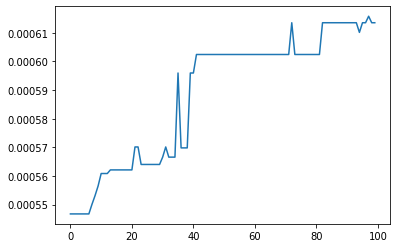

In [25]:
plt.plot(skorlar)